# UE1: Interlab Comparison
A world-wide scientific study requests data from different labs to get as comprehensive analyses as possible for a global study. Per county a different number of labs agree to participate and they agree to submit data of concentration levels of the requested parameter. 

You are the person who must decide if the submitted data can be included to the global study. Consider the first data set to be the data from other countries/continents.

_What do you gave to consider? Can I combine the data to one data set?_ 

_What are you doing with the data?test set: Gaussian distributed? test set(s): variance comparable to other data?_

_What is your result?_

To assess the data submitted by different labs for inclusion in a global scientific study, firstly a quality check and looking at the consistency of the data is seems sensible: Are the concentration levels reported in the same units across all labs?
Are the methodologies used by the labs consistent or comparable? Differences in measurement techniques could introduce bias. These questions are not answerable with the specification given for the assignment, so I assume both of these questions can be answered with 'Yes'. What is possible though, is to check for extreme outliers or other irregularities that could skew the global analysis. 

In [1]:
import pandas as pd
data = pd.read_csv('Bsp2.txt', sep='\t')
data = data.replace(',', '.', regex=True)
data['Liste 1'] = pd.to_numeric(data['Liste 1'], errors='coerce')
data['Liste 2'] = pd.to_numeric(data['Liste 2'], errors='coerce')
data['Liste 3'] = pd.to_numeric(data['Liste 3'], errors='coerce')
data.describe()


,Liste 1,Liste 2,Liste 3
count,15.000000,15.000000,15.000000
mean,999.997262,999.979457,999.370667
std,0.045506,0.021834,0.110160
min,999.918225,999.927671,999.160000
25%,999.965344,999.967604,999.295000
50%,1000.007638,999.982193,999.400000
75%,1000.027353,999.999548,999.430000
max,1000.064897,1000.005062,999.570000


When comparing the means of Liste 1, 2 and 3 it is noticable that Liste 3's mean is significantly lower than the means of Liste 1 (global data). This suggests that Liste 3 might not be directly comparable to our global data, whereas the means of Liste 1 and 2 are more or less the same making them compatible. Looking at the 25th, 50th, and 75th percentiles, Liste 3 has significantly lower numbers than Liste 1 and 2 meaning that a substantial portion of the data in Liste 3 is shifted toward lower values. In Liste 2 the standard deviation is smaller than in Liste 1 but since the mean is approximately the same it is not as critical. Also, the standard deviation of Liste 3 is more than double of the standard deviation of Liste 1, indicating much higher spread in data and maybe a different underlying distribution. So the next step will be to check for normal distribution.

In [2]:
from scipy import stats
data_clean = data.dropna()
for x in range(1, 4):
    shapiro_test = stats.shapiro(data_clean['Liste ' + str(x)])
    print('Liste ' + str(x) + ':')
    print('Shapiro-Wilk Test Statistic:', shapiro_test.statistic)
    print('p-value:', shapiro_test.pvalue)


Liste 1:
Shapiro-Wilk Test Statistic: 0.9455969095194531
p-value: 0.45795323096212953
Liste 2:
Shapiro-Wilk Test Statistic: 0.9182950875354612
p-value: 0.181428123489205
Liste 3:
Shapiro-Wilk Test Statistic: 0.9753398306633886
p-value: 0.927756056691418


The next step is to check for normal distribution. Therefor a Shapiro Wilk Test, which is one of the most powerful tests available for small sample sizes, is conducted with all datasets. The null hypothesis of the test is that data is normally distributed and if the p-value is less than a chosen significance level (commonly 0.05 --> accepting 5% chance of incorrectly rejecting null hypothesis), you reject the null hypothesis that the data is normally distributed. As can be seen in the results of the Shapiro Wilk Test, for each List there is not enough evidence to reject null hypothesis. So all the datasets can be assumed to be normally distributed, although Liste 3 shows the least evidence against the null hypothesis of normality (highest p-value) - most consistent with being normally distributed. To test if the observed difference between means is statistically significant, a t-test is performed. 

In [7]:
t_stat, p_value = stats.ttest_ind(data_clean['Liste 1'], data_clean['Liste 2'], equal_var=False)
print('Liste 1 & 2:')
print(f'T-test Statistic: {t_stat}')
print(f'p-value: {p_value}')
t_stat, p_value = stats.ttest_ind(data_clean['Liste 1'], data_clean['Liste 3'], equal_var=False)
print('Liste 1 & 3:')
print(f'T-test Statistic: {t_stat}')
print(f'p-value: {p_value}')

Liste 1 & 2:
T-test Statistic: 1.3662713604886012
p-value: 0.18692985039423599
Liste 1 & 3:
T-test Statistic: 20.360882936797044
p-value: 3.425368014342746e-14


For the t-test the null hypothesis is the equality of means of the two datasets. The calculated t-statistic indicate how many standard errors the difference between the means is away from zero and the p-value helps to determine the statistical significance (if less than significance level null hypothesis is rejected). The results of this show clearly that the difference between the means of Liste 1 and 3 are statistically significant and more than 20 standard errors away from zero. Still the null hypothesis is also rejected for the means of Liste 2 and 1 but with a notably smaller standard error of the distance between them. Visualizing the data will make the normal distribution and difference of means more comprehensible.  


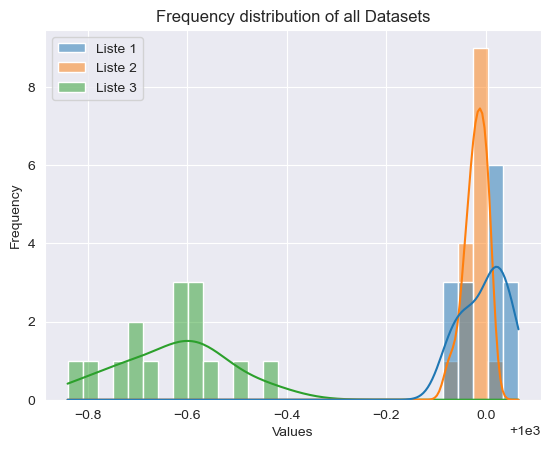

In [3]:
import seaborn as sns
import matplotlib.pyplot as plot
sns.histplot(data, kde=True, bins=30)
plot.title('Frequency distribution of all Datasets')
plot.xlabel('Values')
plot.ylabel('Frequency')
plot.show()

Visualizing the distributions in one plot not only somewhat confirms the underlying normal distribution but shows us how big the difference between the data of Liste 1/2 and Liste 3 is. This makes it clearer that combining Liste 3 with the global data would not work and just skew the data. Also, even if the data is normally distributed, checking whether the variability (variance) of the new datasets is similar to that of the existing dataset from other countries or continents is important an important factor for comparability.

In [145]:
levene_stat, levene_pvalue = stats.levene(data_clean['Liste 1'], data_clean['Liste 2'])
print('Liste 1 and 2:')
print('Levene\'s Test Statistic:', levene_stat)
print('p-value:', levene_pvalue)
levene_stat, levene_pvalue = stats.levene(data_clean['Liste 1'], data_clean['Liste 3'])
print('Liste 1 and 3:')
print('Levene\'s Test Statistic:', levene_stat)
print('p-value:', levene_pvalue)

Liste 1 and 2:
Levene's Test Statistic: 6.443159394760461
p-value: 0.016982922915622155
Liste 1 and 3:
Levene's Test Statistic: 5.393129018807742
p-value: 0.027708767347466853


Testing for comparable variances with the Levene's Test shows assumption of homogeneity of variances is violated. The null hypothesis of the test is that the data's variances are equal and if the p-value is less than a chosen significance level (commonly 0.05 --> accepting 5% chance of incorrectly rejecting null hypothesis), you reject the null hypothesis about homogeneity. Combining datasets with significantly different variances can lead to misleading conclusions, loss of information, skewness and invalidate the results of subsequent analyses, so it is not recommendable to combine the datasets. If datasets have different variances, the combined dataset may not accurately reflect the individual characteristics of each group. This could lead to researchers making broader claims based on results that do not apply equally across all subgroups.

### Conclusion
Due to significant differences in variances (Levene's Test) and means (t-test) of Liste 2 and 3 from global data Liste 1, the recommendation would be not to combine either one with the global data. The data sets are simply too different to combine them and expect one homogenous set. It would be hard to make a statement that is true for all data, which deminishes the purpose of combining the sets in the first place.  

But if one dataset has to be combined it should be Liste 1 (global) and Liste 2. Eventhough their means are significantly distanced from each other (as shown in the t-test) they are closer together than any of the other combinations which could make the difference in variance more acceptable because data points of Liste 2 would be more centered around the common mean without introducing any outliers. Also, they are both not proven wrong on underlying normal distribution. Liste 3 does not seem comparable in any way to the global dataset, its distribution is shifted too much toward lower values noticable in the quartiles. The mean is more than 20 standard errors away from global mean and additionally variance is much greater than in Liste 1. The combination of these two datasets would lead to unnormalizing the distribution by having all data points of Liste 3 as outliers, skewing the distribution. Maybe the methodologies used by the labs are indeed NOT consistent and this leads to the displacement of the data in Liste 3. 